# 갤럭시 Z Flip 네트워크 분석

## 리뷰 데이터
1. 총 **2577 문장** 사용 
2. 영어/특수문자/숫자 제거 후 **한글만 사용**
3. Konlpy Okt 패키지 이용해서 한글 데이터 중 **형용사와 명사**만 추출
4. 불용어 사전 구축 후 분석과 관련 없는 **불용어 제거**
5. 형용사 모두 원형으로 맞춰줌 (좋게 -> 좋다 / 예쁜 -> 예쁘다)

## 리뷰 내 단어 수
1. Counter 패키지 이용해서 문서 내 **형용사와 명사의 단어 수 Count**

## 네트워크 분석
1. **동시발생행렬**(Co-occurrence) 구축
2. 네트워크 분석을 위한 **Edge Data** (Source-Target-Weight-Weightcustom) 구축  
    1) Source(단어)와 Target(단어)의 Weight(동시등장발생빈도)를 뜻함  
    2) weightcustom은 Weight으로 그래프를 그렸을 때 노드사이의 거리가 너무 가까워서 임의로 weight값에 10을 곱해 준 값  
3. 간결한 네트워크 시각화를 위해 **Weight가 13 이하인 연결은 모두 삭제 (조정 가능)**
4. Node의 크기는 **리뷰 내 단어 수에 비례함** 
5. Node의 **그룹화**는 commnuity 패키지 사용
6. Edge **선 굵기는 Weight에 비례**
7. 시각화

## 근접 중심성 분석
1. 해당 Node가 얼마나 다른 Node들의 중심에 있는지 나타냄  
    1) 최단거리 합의 역수, 중심에 있을 수록 큰 값

In [1]:
import numpy as np
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

from konlpy.tag import Okt
okt = Okt()

In [ ]:
#리뷰 데이터 파일 open

f = pd.read_csv("flipy.csv", error_bad_lines=False,encoding='utf-8-sig')
f

In [ ]:
#영어/특수문자/숫자 삭제 후 한글만 남김

f['korean']= f['sentence'].str.replace(pat=r'[^가-힣]', repl= r' ', regex=True)
f

In [5]:
# 형용사/명사만 남김

ko = []

for line in f['korean']:
    sentence_tag=[]
    morph = okt.pos(line, norm=True, stem=True)
    sentence_tag.append(morph)
    
    noun_adj_list=[] 
    for sentence1 in sentence_tag:
        for word, tag in sentence1:
            if tag in ['Noun', 'Adjective']:
                noun_adj_list.append(word)
                
    
    ko.append(noun_adj_list)

In [ ]:
#List of list DㅐataFrame에 삽입

f['manufacturing'] = pd.Series(ko)
f

In [ ]:
# 불용어제거

temp=[]

with open('./stop_words.txt', 'r',encoding='utf-8') as stop:
    lines = stop.readlines()
    for line in lines:
        line=re.sub('\n','',line,0).strip()
        temp.append(line)

stop_words=' '.join(map(str, temp))
stop_words=stop_words.split(' ')

f['stopwords']=f['manufacturing'].apply(lambda x: [word for word in x if word not in stop_words])
f['stopwords']=f['stopwords'].apply(lambda x : [word for word in x if len(word) > 1])
f

In [710]:
# 이쁘다 = 예쁘다 맞춰 줌

for sen in f['stopwords']:
    for n, i in enumerate(sen):
        if i == '이쁘다':
            sen[n] = '예쁘다'

In [711]:
#DataFrame List로 변환

dataset=[]
dataset = f['stopwords'].values.tolist()

In [712]:
# 리뷰 내 단어 수 Count

counter = Counter(x for xs in dataset for x in set(xs))
count = pd.DataFrame(counter.most_common(300))
count = count.rename(columns= {0:'source', 1:'count'})
count.to_csv("flipyCount.csv", encoding='utf-8-sig', index=False)
count[:10]

,source,count
0,좋다,242
1,같다,229
2,없다,211
3,화면,183
4,예쁘다,170
5,카메라,112
6,아니다,109
7,액정,94
8,사진,82
9,필름,81


In [713]:
#동시발생행렬 구축

u = (pd.get_dummies(pd.DataFrame(dataset), prefix='', prefix_sep='')
       .groupby(level=0, axis=1).sum())

v = u.T.dot(u)
v.values[(np.r_[:len(v)], ) * 2] = 0

In [715]:
pd.DataFrame(v).to_csv("flipyCo.csv", encoding='utf-8-sig')

In [716]:
#동시발생행렬 결과

pd.DataFrame(v)

,가가,가격,가기,가까이,가깝다,가끔,가나,가능성,가능하다,가득,...,희귀,희다,희망,흰둥이,흰색,힌지,힘드다,힘들다,힘없다,힙생힙사
가가,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
가격,0,0,0,0,1,0,0,0,3,0,...,0,0,0,0,0,0,0,6,0,0
가기,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
가까이,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
가깝다,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
힌지,0,0,0,1,0,0,0,2,5,0,...,0,0,0,0,0,0,0,4,0,0
힘드다,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힘들다,0,6,2,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
힘없다,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [717]:
# 네트워크 분석을 위한 Source-Target-Weight DataFrame 구축
# Weightcustom은 weight*10의 값 / 그래프에서 노드끼리의 거리 증가를 위함

a = v.stack()
a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='weight')
a['weightcustom'] = (a['weight']*10)
a

,source,target,weight,weightcustom
0,가가,개봉,1,10
1,가가,높다,1,10
2,가가,대표,1,10
3,가가,브랜드,1,10
4,가가,삼색,1,10
...,...,...,...,...
69847,힙생힙사,겉모습,1,10
69848,힙생힙사,당첨,1,10
69849,힙생힙사,로써,1,10
69850,힙생힙사,색상,1,10


In [718]:
pd.DataFrame(a).to_csv("flipyEd.csv", encoding='utf-8-sig', index=False)

In [771]:
#네트워크분석 그래프 구축

import networkx as nx
G = nx.from_pandas_edgelist(a,  edge_attr=True)

# Weight가 일정값 이하인 노드 삭제

def drop_low_weighted_edge(inputG, above_weight=3):
    rG = nx.Graph()
    rG.add_nodes_from(inputG.nodes(data=True))
    edges = filter(lambda e: True if e[2]['weightcustom']>=above_weight else False, inputG.edges(data=True))
    rG.add_edges_from(edges)

    for n in inputG.nodes():
        if len(list(nx.all_neighbors(rG, n)))==0:
            rG.remove_node(n)
    return rG

G= drop_low_weighted_edge(G, 130)

In [835]:
#노드끼리의 거리 / 그래프 레이아웃 등 결정
#노드의 크기는 단어등장개수 (Count 한 값)

pos=nx.spring_layout(G, k=1,iterations=50, scale=2)
pr = nx.pagerank(G)
degree = nx.degree(G)

for i in list(G.nodes()): 
    try:
        G.nodes[i]['counter'] = counter[i]
    except:
        G.nodes[i]['counter'] = 3

In [842]:
#그래프 군집화 및 색상 사이즈 결정

import community.community_louvain

node_color = [G.degree(v) for v in G] 
node_size = [50 * nx.get_node_attributes(G, 'counter')[v] for v in G] 
partition = community.community_louvain.best_partition(G)

In [843]:
#글씨체 적용

import matplotlib.font_manager as fm
from matplotlib import rc
font_name= fm.FontProperties(fname=r"C:\Users\Hyennnnnnnnnnnn\Desktop\창종설\NanumBarunGothicBold.ttf").get_name()

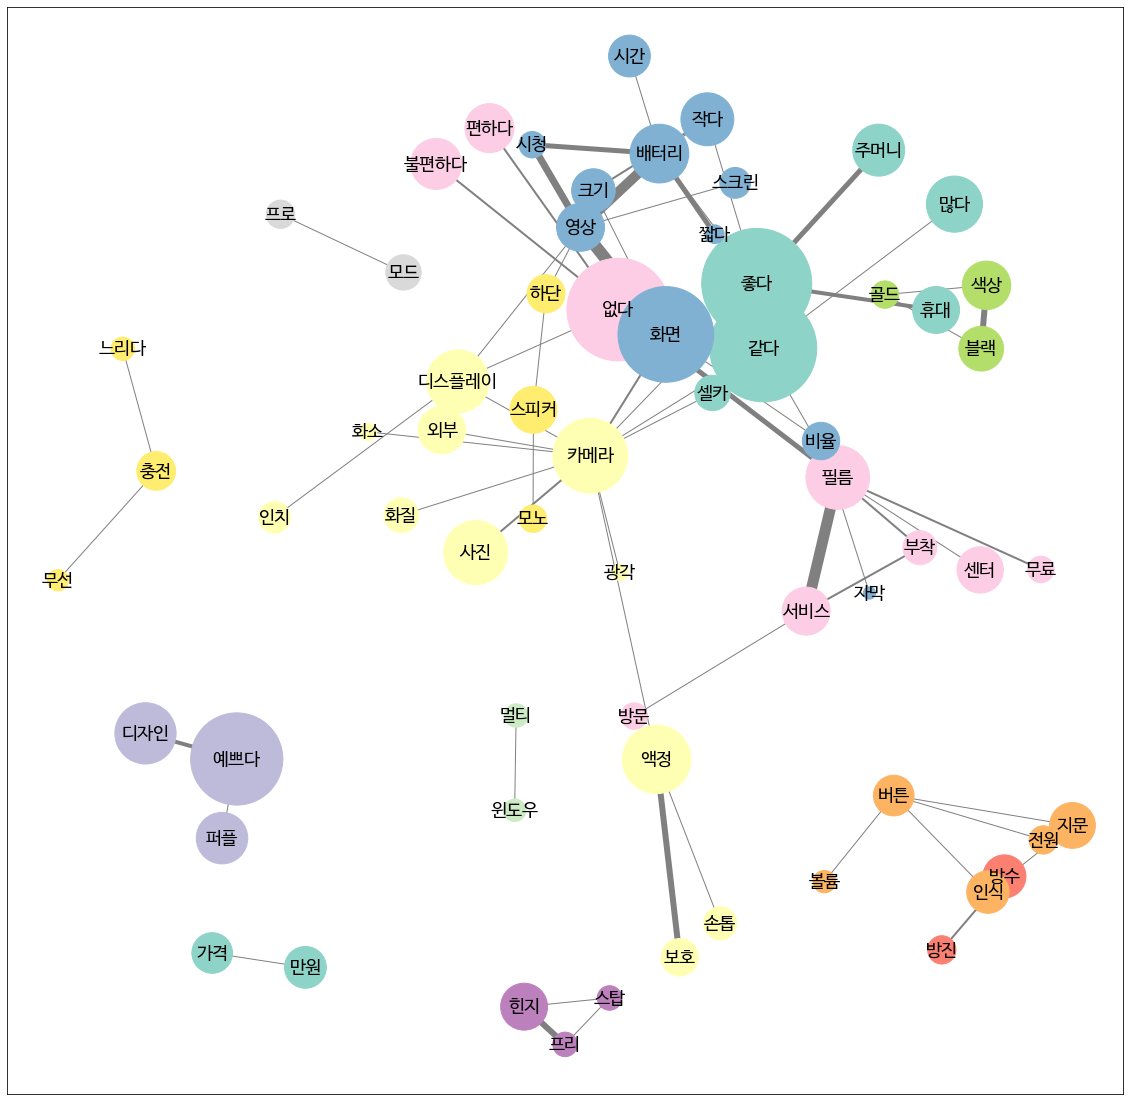

In [844]:
#네트워크분석 그래프 시각화

plt.figure(figsize=(20,20))

labels = nx.get_edge_attributes(G, 'weightcustom')

nx.draw_networkx(G, pos, node_size = node_size,
                 node_color = list(partition.values()),
                 edge_color='Gray', width= (a['weight']),
                 font_family=font_name, font_color = 'black',
                 with_labels = True, edge_labels = labels,
                 cmap=plt.cm.Set3, font_size = 18)

plt.savefig("flip130.png")

In [858]:
#근접중심성 분석

close = nx.closeness_centrality(G, distance=None, wf_improved=True)

#근접중심성 결과

close = pd.DataFrame.from_dict(close, orient = 'index').rename(columns= {0:'closeness'})
close = close.sort_values(by=['closeness'], axis=0, ascending=False)
close.to_csv("flipyclose.csv", encoding='utf-8-sig', index=True)
close

,closeness
카메라,0.276344
같다,0.273168
화면,0.270064
좋다,0.258322
디스플레이,0.255544
...,...
방수,0.015625
방진,0.015625
멀티,0.015625
프로,0.015625
